In [1]:
# General
import numpy as np
import torch
import torch.nn.functional as F
from importlib import reload
from types import SimpleNamespace
import shap
import torch_geometric
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
from torch_geometric.explain import Explainer, GNNExplainer
from sklearn.metrics import accuracy_score

# Custom
import utils
reload(utils)

import data
reload(data)

import train
reload(train)

import modules
reload(modules)
from modules import GCN, GCN_GNNExplainer, GCN_GraphSVX
from modules import GraphSAGE
from torch_geometric.data import DataLoader
import torch.optim as optim

import explanations
reload(explanations)
from explanations import LIME_explanation, SHAP_explanation

import GraphSVX_explainers
reload(GraphSVX_explainers)
from GraphSVX_explainers import GraphSVX, GraphLIME

%matplotlib inline


# Load model

In [2]:
# Choose model and dataset here
model_name = 'GAT'
dataset_name = '100K_accts_EASY25'

# Load model, data, and other variables
model_path = f'trained_models/{model_name}_{dataset_name}.pth'

checkpoint = torch.load(model_path)
model_state_dict = checkpoint['model_state_dict']
hyperparameters = checkpoint['hyperparameters']
traindata = checkpoint['traindata']
testdata = checkpoint['testdata']
#feature_names = checkpoint['feature_names']
feature_names = ['account', 'sum', 'mean', 'median', 'std', 'max', 'min', 'in_sum', 'out_sum', 'in_mean', 'out_mean', 'in_median', 'out_median', 'in_std', 'out_std', 'in_max', 'out_max', 'in_min', 'out_min', 'count_in', 'count_out', 'n_unique_in', 'n_unique_out', 'count_days_in_bank', 'count_phone_changes', 'sum_spending', 'mean_spending', 'median_spending', 'std_spending', 'max_spending', 'min_spending', 'count_spending']
target_names = checkpoint['target_names']
running_train_loss = checkpoint['running_train_loss']
running_test_loss = checkpoint['running_test_loss']
accuracy = checkpoint['accuracy']

# Initialize model
if model_name == 'GAT':
    in_channels = traindata.x.shape[1]
    hidden_channels = hyperparameters['hidden_channels']
    out_channels = 2
    num_heads = hyperparameters['num_heads']
    dropout = hyperparameters['dropout']
    model = modules.GAT_GraphSVX_foroptuna(in_channels = in_channels, hidden_channels=hidden_channels, out_channels=out_channels, num_heads=num_heads, dropout=dropout)

model.load_state_dict(checkpoint['model_state_dict'])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
traindata = traindata.to(device)
testdata = testdata.to(device)
model.eval()

Can't initialize NVML


GAT_GraphSVX_foroptuna(
  (conv1): GATConv(31, 15, heads=3)
  (conv2): GATConv(45, 15, heads=3)
  (conv3): GATConv(45, 15, heads=1)
  (MLP_post1): Linear(in_features=15, out_features=15, bias=True)
  (MLP_post2): Linear(in_features=15, out_features=2, bias=True)
  (log_softmax): LogSoftmax(dim=1)
)

# Run GraphSVX

In [3]:
from sklearn.metrics import confusion_matrix

# Set return type of model to log_probas for explainer compatibility
model.set_return_type('log_probas')


model.eval()
with torch.no_grad():
    y_probas = model.forward(testdata.x, testdata.edge_index)
    y_probas = torch.exp(y_probas)
    y_pred = y_probas.cpu().numpy().argmax(axis=1)    
    y_true = testdata.y.cpu().numpy()
    cm = confusion_matrix(y_true, y_pred)
    print(cm)

sar_indices = np.where(y_pred == 1)[0]
print(f'Nodes predicted as SAR: {sar_indices}')

[[68689  8019]
 [ 8337 14876]]
Nodes predicted as SAR: [    0     5     9 ... 99881 99890 99910]


In [44]:
node_to_explain = sar_indices[3].item()
#testdata_expl, org_to_new_mapping, new_to_org_mapping = utils.build_subgraph(testdata, node_to_explain, 3)
subset_expl, edge_index_expl, _, _ = torch_geometric.utils.k_hop_subgraph(node_to_explain, 3, testdata.edge_index, relabel_nodes=False)
org_to_new_mapping, new_to_org_mapping, edges_new = utils.node_index_mapping(subset_expl, edge_index_expl)
testdata_expl = Data(x = testdata.x[subset_expl], edge_index = edges_new, y = testdata.y[subset_expl])

# n_hops_in_expl = 3
# subset_plot, edge_index_plot, _, _ = torch_geometric.utils.k_hop_subgraph(node_to_explain, n_hops_in_expl, testdata.edge_index, relabel_nodes=False)
# org_to_new_mapping, new_to_org_mapping, edges_new = utils.node_index_mapping(subset_plot, edge_index_plot)
# testdata_plot = Data(x = testdata.x[subset_plot], edge_index = edges_new, y = testdata.y[subset_plot])

# # Unit test for checking that all nodes have neighbours
# n_nodes = testdata_expl.x.shape[0]
# print(n_nodes)
# node_indices = testdata_sub.edge_index.flatten()
# count = 0
# for i in range(n_nodes):
#     if (sum(node_indices == i) == 0):
#         count = count + 1
#         print(count)
# print(f'Total count = {count}')

In [5]:
#Unit test for org_to_new_mapping and new_to_org_mapping
# plt.clf
# print('Testing org_to_new_mapping: ', end = '')
# for i in range(len(subset)):
#     assert org_to_new_mapping[subset[i].item()] == i, "Something is wrong with org_to_new_mapping"
# print('\033[92mTEST PASSED\033[0m')


# print('Testing new_to_org_mapping: ', end = '')
# for i in range(len(subset)):
#     assert new_to_org_mapping[i] == subset[i].item(), "Something is wrong with new_to_org_mapping"
# print('\033[92mTEST PASSED\033[0m')

# Checking if subgraph has any disconnected nodes
# plt.figure()
# G_new = to_networkx(testdata_expl)
# nx.draw(G_new, with_labels=True)

In [47]:
# Printing info about the explained node
#node_to_explain = sar_indices[1].item()
print(f'Explaining node {node_to_explain} which was prediced SAR.')
print(f'The node was predicted SAR (label 1) with probability {y_probas[node_to_explain][1]:.4f}.')
print(f'The true label is {testdata.y[node_to_explain]}.\n')

# NOTE: The subgraph is being extraced above. Maybe move everything here later for clarity
# # Using only the relevant subgraph for quicker computations
# testdata_sub, org_to_new_mapping, new_to_org_mapping = utils.build_subgraph(testdata, node_to_explain, 3)
# testdata_sub = torch_geometric.transforms.ToUndirected()(testdata_sub)

# Running the explainer
testdata_expl = testdata_expl.to('cpu')
model = model.to('cpu')

print(testdata_expl.edge_index.shape)

data = SimpleNamespace()
data.x = testdata_expl.x
data.edge_index  = testdata_expl.edge_index
data.y = testdata_expl.y
data.num_classes = 2
data.num_features = 10
data.num_nodes = testdata_expl.x.shape[0]
data.name = 'test'

explainer = GraphSVX(data, model, True)
explanations = explainer.explain(node_indexes=[0], num_samples=2638, hops = 3, vizu = False)

# model = model.to('cuda:0')
# testdata_expl = testdata_expl.to('cuda:0')

Explaining node 10 which was prediced SAR.
The node was predicted SAR (label 1) with probability 0.6185.
The true label is 1.

torch.Size([2, 2638])


2638it [04:06, 10.72it/s]


r2:  0.938733406614106
weighted r2:  0.9999623679444385
Explanations include 12 node features and 1268 neighbours for this node        for 2 classes
Model prediction is class 1 with confidence 0.618531346321106, while true label is 1
Base value 0.9138026420079702 for class  1
Weights for node features:  -0.3228195182356522 and neighbours:  0.027548140096344074
Most influential features:  1 and neighbours 5
Most influential features:  [(20, -0.2344215034287159), (18, -0.05988980111470448), (6, -0.01973970888256448)]
Most influential neighbours:  [(1262, -0.4613556126429), (1242, -0.46051709671141133), (1074, -0.4598241269761927)]
Time:  320.3407402038574


Explaining node 10 which was prediced SAR.
The node was predicted SAR (label 1) with probability 0.6185.
The true label is 1.

Number of SVs 1280
1280
1269
1269
ding
Length of size_map: 1269
Number of nodes in the graph: 1269
12


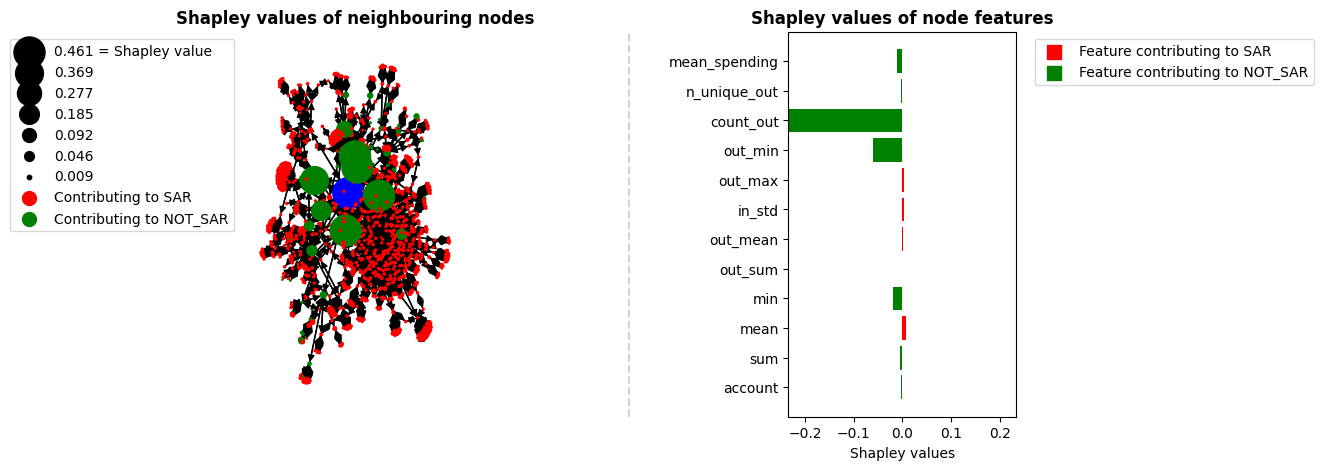

In [48]:
G = to_networkx(testdata_expl)
# nx.draw(G, with_labels=True)

# --- Printing information about node prediction ---
print(f'Explaining node {node_to_explain} which was prediced SAR.')
print(f'The node was predicted SAR (label 1) with probability {y_probas[node_to_explain][1]:.4f}.')
print(f'The true label is {testdata.y[node_to_explain]}.\n')

# --- Extract Shapley values ---
F = explainer.F
D = explanations[0].shape[0] - F
SV = explanations[0]
SV_features = SV[:F]
SV_nodes = SV[F:]

print(f'Number of SVs {len(SV)}')

# Node coloring
color_map = ['blue']
size_map = [500]
labels = {0: node_to_explain}
SV_max = np.abs(SV_nodes).max()
SV_min = np.abs(SV_nodes).min()
for i in range(len(SV_nodes)): 
    SV_node = SV_nodes[i]
    size_map.append(500 * np.abs(SV_node) / SV_max)
    labels[i+1] = new_to_org_mapping[i+1]
    if SV_node < 0:
        color_map.append('green')
    else: 
        color_map.append('red')

print(len(SV))
print(len(size_map))
print(testdata_expl.x.shape[0])

# Create figure
fig = plt.figure(figsize=(10, 5))

# --- Subplot for nodes ---
plt.subplot(1,3,1)

pos = nx.spring_layout(G)
print('ding')
#pos = nx.kamada_kawai_layout(G)
print("Length of size_map:", len(size_map))
print("Number of nodes in the graph:", len(G.nodes))


nx.draw(G, pos=pos, with_labels=False, labels=labels, node_color=color_map, node_size=size_map, font_size=7, font_weight='bold')


# Add legend
plt.scatter([], [], c='black', s=500, label=f'{SV_max:.3f} = Shapley value')
plt.scatter([], [], c='black', s=400, label=f'{4/5*SV_max:.3f}')
plt.scatter([], [], c='black', s=300, label=f'{3/5*SV_max:.3f}')
plt.scatter([], [], c='black', s=200, label=f'{2/5*SV_max:.3f}')
plt.scatter([], [], c='black', s=100, label=f'{1/5*SV_max:.3f}')
plt.scatter([], [], c='black', s=50, label=f'{50/500*SV_max:.3f}')
plt.scatter([], [], c='black', s=10, label=f'{10/500*SV_max:.3f}')
plt.scatter([], [], c='red', s=100, label='Contributing to SAR')
plt.scatter([], [], c='green', s=100, label='Contributing to NOT_SAR')
plt.legend(bbox_to_anchor=(0, 1),loc='upper right')

plt.title('Shapley values of neighbouring nodes',fontweight='bold')

# --- Add vertical line to separate the plots ---
plt.subplot(1, 3, 2)
plt.axvline(x=5, color='lightgray', linestyle='--')
plt.axis('off')  # Turn off axis

# --- Shapley Values for features ---
plt.subplot(1, 3, 3)
# Extract features that are used in the explanation, and get their original feature names
feat_idx, discarded_feat_idx = explainer.feature_selection(0, "Expectation") # Using 0 here since 0 is node_to_explain in the subgraph
print(len(feat_idx))
feature_names_in_explanation = [feature_names[i] for i in feat_idx]

colors = ['green' if e < 0 else 'red' for e in SV_features]
plt.barh(range(len(SV_features)), SV_features, color=colors)
xlim = np.abs(SV_features).max()
plt.xlim(-xlim, xlim)
plt.yticks(range(len(SV_features)), feature_names_in_explanation)
plt.xlabel('Shapley values')
plt.scatter([], [], c='red', s=100, marker = 's', label='Feature contributing to SAR')
plt.scatter([], [], c='green', s=100, marker = 's', label='Feature contributing to NOT_SAR')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Shapley values of node features',fontweight='bold')

# --- Plot figures ---
plt.show()

No shapley value bigger than 0.11000000000000001. Stopping.


Text(0, 0.5, 'Number of suspicious neighbours')

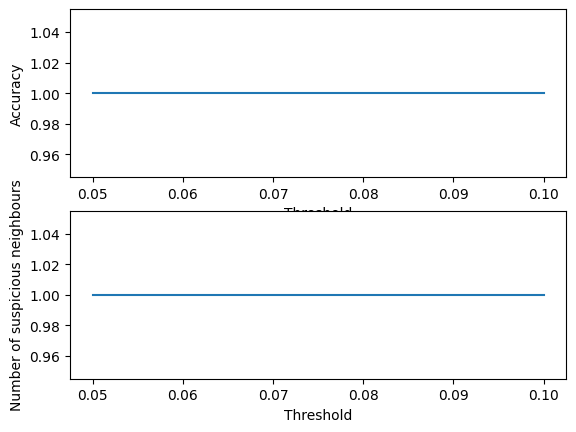

In [50]:
import numpy as np

accuracy = []
n_sus_neighbours = []
threshholds = np.arange(0.05,0.5,0.01)
for thresh in threshholds:
    suspicious_neighbours_orgidx = []
    suspicious_neighbours_sv = []
    suspicious_neighbours_ypred = []
    suspicious_neighbours_y = []
    
    for node_idx, sv in enumerate(SV_nodes):
        
        node_idx = node_idx + 1 #sv at position 0 corresponds to node 1 (since node 0 is not assigned a Shapley value)
        if sv > thresh:
            #suspicious_neighbours_orgidx.append(new_to_org_mapping[node_idx].item())
            suspicious_neighbours_orgidx.append(node_idx)
            suspicious_neighbours_sv.append(sv)
            suspicious_neighbours_ypred.append(1)
            suspicious_neighbours_y.append(testdata_expl.y[node_idx].item())

    if len(suspicious_neighbours_orgidx) == 0:
        print(f'No shapley value bigger than {thresh}. Stopping.')
        break
    
    tmp = accuracy_score(suspicious_neighbours_y, suspicious_neighbours_ypred)
    accuracy.append(tmp)
    n_sus_neighbours.append(len(suspicious_neighbours_ypred))

    # for orgidx, sv, y in zip(suspicious_neighbours_orgidx, suspicious_neighbours_sv, suspicious_neighbours_y):
    #     print(f'Node {orgidx} suspicious neighbour with Shapley Value = {sv} and true label {y}')
    
    # print(suspicious_neighbours_ypred)
    # print(suspicious_neighbours_y)
    

threshholds = threshholds[0:len(accuracy)]

plt.figure()
plt.subplot(2,1,1)
plt.plot(threshholds, accuracy)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.subplot(2,1,2)
plt.plot(threshholds, n_sus_neighbours)
plt.xlabel('Threshold')
plt.ylabel('Number of suspicious neighbours')
# for  in range(len(suspicious_neighbours)):
#     print(f'Node {} suspicious neighbour with Shapley Value = {SV_nodes[node_idx]:.4f} and true label {suspicious_neighbours_y[node_idx]}')

# Run GNNExplainer

Node to explain: 13


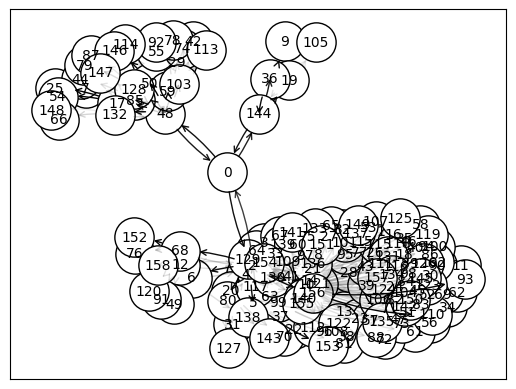

In [18]:
print(f'Node to explain: {node_to_explain}')

model.cpu()
testdata_expl.cpu()

explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='probs',  # Model returns log probabilities.
    ),
)

explanation = explainer(testdata_expl.x, testdata_expl.edge_index, index=0)

#explanation.visualize_feature_importance(top_k=10)
explanation.visualize_graph()

# Run LIME and SHAP

In [51]:
# --- LIME ---
num_features = 10
class_prob_fn = model.forward_NFVinput

# Prepare the model for handling the LIME explainer
model.set_test_data(testdata_expl)
model.set_node_to_explain(0)

exp_LIME = LIME_explanation(node_to_explain = node_to_explain,
                                    num_features = num_features,
                                    class_prob_fn = class_prob_fn,
                                    testdata = testdata,
                                    feature_names = feature_names,
                                    target_names = target_names)

exp_LIME.show_in_notebook(show_table=True, show_all=False)


# --- SHAP ---
K = 20
class_prob_fn = model.forward_NFVinput

exp_SHAP = SHAP_explanation(node_to_explain = node_to_explain,
                                         class_prob_fn = class_prob_fn,
                                         backgrounddata = traindata,
                                         explaindata = testdata,
                                         feature_names = feature_names,
                                         K = K)

shap.plots.waterfall(exp_SHAP[0])

Starting forward_NFVinput...
Setting return type of forward pass to "logits" so that forward_NFVinput returns "probas"...
Number of samples = 5000
Loading data...
number of graphs = 5000
Loading data into a single batch...
Starting forward pass...


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat2 in method wrapper_CUDA_mm)